In [1]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.python.framework import ops
import random
from IPython.display import display, clear_output
import sys

In [2]:
gHidden1OutputSize = 500 #19
pHidden1OutputSize = 500 #32
sHidden1OutputSize = 500 #30
hidden2OutputSize = 1
seed = 0
batchSize = 100
trainingRatio = 0.9

In [3]:
#Load the features into arrays
inputFile = 'features.pckl'
with open(inputFile, 'rb') as fid:
    features = pickle.load(fid)
random.shuffle(features)
numSamples = len(features)


In [4]:
cutIndex = int(numSamples*trainingRatio)
trainingFeatures = features[:cutIndex]
testFeatures = features[cutIndex:]

In [5]:
def splitAndBatchFeatures(batchSize, features):
    random.shuffle(features)
    globalFeatures = np.array([feature['globalFeatures'] for feature in features], dtype='float32')
    pieceFeatures  = np.array([feature['pieceFeatures'] for feature in features], dtype='float32')
    squareFeatures = np.array([feature['squareFeatures'] for feature in features], dtype='float32')
    ranks = np.array([feature['moveRankings'] for feature in features], dtype='float32')
    labels = np.array([feature['labels'] for feature in features], dtype='float32')

    globalLength= globalFeatures.shape[1]
    pieceLength = pieceFeatures.shape[1]
    squareLength = squareFeatures.shape[1]
    #reshape the arrays into batches
    numSamples = globalFeatures.shape[0]
    goalNumSamples = numSamples - numSamples%batchSize
    #trim samples to fit evenly into batches
    globalFeaturesTrim = globalFeatures[:goalNumSamples, :]
    pieceFeaturesTrim = pieceFeatures[:goalNumSamples, :]
    squareFeaturesTrim = squareFeatures[:goalNumSamples, :]
    ranksTrim = ranks[:goalNumSamples, :]
    labelsTrim = labels[:goalNumSamples, :]

    #reshape into batches
    globalBatchFeed = globalFeaturesTrim.reshape(-1, batchSize, globalLength)
    pieceBatchFeed = pieceFeaturesTrim.reshape(-1, batchSize, pieceLength)
    squareBatchFeed = squareFeaturesTrim.reshape(-1, batchSize, squareLength)
    rankBatchFeed = ranksTrim.reshape(-1, batchSize, 1)
    labelBatchFeed = labelsTrim.reshape(-1, batchSize, 1)
    
    return globalBatchFeed, pieceBatchFeed, squareBatchFeed, rankBatchFeed, labelBatchFeed

#Test
g, p, s, r, l = splitAndBatchFeatures(batchSize, trainingFeatures)

In [6]:
print g.shape, p.shape, s.shape, r.shape, l.shape

(10536, 100, 19) (10536, 100, 160) (10536, 100, 144) (10536, 100, 1) (10536, 100, 1)


In [7]:
tf.reset_default_graph()

'''globalTensor = tf.convert_to_tensor(globalFeatures, dtype=tf.float32)
pieceTensor = tf.convert_to_tensor(pieceFeatures, dtype=tf.float32)
squareTensor = tf.convert_to_tensor(squareFeatures, dtype=tf.float32)
rankTensor = tf.convert_to_tensor(ranks, dtype=tf.float32)
labelTensor = tf.convert_to_tensor(labels, dtype=tf.float32)

train_input_queue = tf.train.slice_input_producer(
                                    [globalFeatures, 
                                     pieceFeatures, 
                                     squareFeatures,
                                     ranks,
                                     labels],
                                    shuffle=False)

globalBatch, pieceBatch, squareBatch, rankBatch, labelBatch = tf.train.batch(
                                    train_input_queue,
                                    batch_size=batchSize
                                    #,num_threads=1
                                    )
'''
globalLength = 19
pieceLength = 160
squareLength = 144

#global variables
with tf.variable_scope('GlobalVariables'):
    globalBatch = tf.placeholder(tf.float32, shape=(batchSize, globalLength), name='GlobalBatch')#1 bit (everything is really just floats)
    #global hidden layer
    gHidden1 = tf.layers.dense(globalBatch, gHidden1OutputSize, name='GlobalHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))
    #testWeights = tf.get_variable("kernel")
#piece-centric variables
with tf.variable_scope('Piece-CentricVariables'):
    pieceBatch = tf.placeholder(tf.float32, shape=(batchSize, pieceLength), name='PieceBatch')

    #piece-centric hidden layer
    pHidden1 = tf.layers.dense(pieceBatch, pHidden1OutputSize, name='Piece-CentricHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))

#square-centric variables
with tf.variable_scope('Sqaure-CentricVariables'):
    squareBatch = tf.placeholder(tf.float32, shape=(batchSize, squareLength), name='SquareBatch')
    rankBatch = tf.placeholder(tf.float32, shape=(batchSize, 1), name='RankBatch')
    squareRankBatch = tf.concat([squareBatch, rankBatch], 1)
    #square-centric hidden layer
    sHidden1 = tf.layers.dense(squareRankBatch, sHidden1OutputSize, name='Square-CentricHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))

input2 = tf.concat([gHidden1, pHidden1, sHidden1], 1)
logits = tf.layers.dense(input2, hidden2OutputSize, name='HiddenLayer2', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))
probability = tf.nn.sigmoid(logits)
labelBatch = tf.placeholder(tf.float32, shape=(batchSize, 1), name='LabelBatch')
loss = tf.losses.sigmoid_cross_entropy(labelBatch, logits) #groundTruth must be of shape [batchSize, 1]
optimizer = tf.train.AdadeltaOptimizer()
trainer = optimizer.minimize(loss)

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
len(features)


1170695

In [9]:
print 'Starting...'
batchesPerEpoch = float(len(features))/batchSize
numEpochs = 1
saveDir = '/home/rvansoelen/rbmcData/savedModels/firstRun/'
saveFrequency = 10000
printFrequency = 1000
saver = tf.train.Saver()
lastSavePath = ''
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    #print sess.run( weights = tf.get_variable("GlobalVariable/kernel"))
    #coord = tf.train.Coordinator()
    #threads = tf.train.start_queue_runners(coord=coord)
    lossRecord = []
    for epoch in range(8):
        globalBatchFeed, pieceBatchFeed, squareBatchFeed, rankBatchFeed, labelBatchFeed = splitAndBatchFeatures(batchSize, trainingFeatures)
        for i in range(globalBatchFeed.shape[0]):
            thisLoss = sess.run((loss, trainer), 
                feed_dict={globalBatch:globalBatchFeed[i], 
                          pieceBatch:pieceBatchFeed[i], 
                          squareBatch:squareBatchFeed[i], 
                          rankBatch:rankBatchFeed[i], 
                          labelBatch:labelBatchFeed[i]
                          })[0]
            lossRecord.append(thisLoss)
            if i % printFrequency == 0:
                print 'Loss: ', thisLoss
            if i % saveFrequency == 0:
                path = saveDir+'model_'+str(epoch)+'_'+str(i)+'.ckpt'
                lastSavePath = saver.save(sess, path)
                print('Saved model at epoch %d, iteration %d' % (epoch, i))
    path = saveDir+'model_'+str(epoch)+'_'+str(i)+'.ckpt'
    lastSavePath = saver.save(sess, path)
    print('Saved model at epoch %d, iteration %d' % (epoch, i))
    print('Done')
    #coord.request_stop()
    #coord.join(threads)
    #coord.request_stop()
    #coord.join(threads)
    '''tf.saved_model.simple_save(sess,
            saveDir,
            inputs={'globalFeatures': train_input_queue[0],
                    'pieceFeatures': train_input_queue[1], 
                    'squareFeatures': train_input_queue[2],
                    'ranks' : train_input_queue[3], 
                    'labels' : train_input_queue[4]},
            outputs={"probability": probability})'''


Starting...
Loss:  2.0078847
Saved model at epoch 0, iteration 0
Loss:  1.7453196
Loss:  1.0776299
Loss:  0.8024835
Loss:  0.7099782
Loss:  0.7230874
Loss:  0.70380574
Loss:  0.69940925
Loss:  0.6931472
Loss:  0.69858176
Loss:  0.6979125
Saved model at epoch 0, iteration 10000
Loss:  0.6931472
Saved model at epoch 1, iteration 0
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Saved model at epoch 1, iteration 10000
Loss:  0.6931472
Saved model at epoch 2, iteration 0
Loss:  0.69492835
Loss:  0.6931472
Loss:  0.7018244
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.69381064
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6999496
Loss:  0.6931472
Saved model at epoch 2, iteration 10000
Loss:  0.6967023
Saved model at epoch 3, iteration 0
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6970539
Loss:  0.6931472
Loss:  0.6931472
Loss:  0.6931472
Loss:

In [10]:
globalBatchFeed.shape

(10536, 100, 19)

In [ ]:
computeTime = 50
def getMoveScores(engine, board):
    moves = list(board.pseudo_legal_moves)
    moves.append(chess.Move(0, 0))
    scores = {}
    for move in moves:
        engine.ucinewgame()
        engine.position(board)
        try:
            engine.go(searchmoves=[move], movetime=computeTime)[0]
            engine.stop()
            scores[move] = infoHandler.info['score'][1].cp
        except chess.uci.EngineTerminatedException as e:
            scores[move] = 0
            #restart engine
            engine = chess.uci.ChessEngine('stockfish')
            engine.uci()
            infoHandler = chess.uci.InfoHandler()
    return scores
    
def benchmarkModelPredict(fenMoveSet): #list of tuples containing fen string and chess.Move
    engine = chess.uci.ChessEngine('stockfish')
    engine.uci()
    infoHandler = chess.uci.InfoHandler()
    engine.info_handlers.append(infoHandler)
    for (fen, move) in fenMoveSet:
        board = chess.Board(fen)
        possibleMoves = board.pseudo_legal_moves
        possibleMoves.append(chess.Move(0,0))
        #get move scores
        scores = getMoveScores(engine, board) 
        if move in scores:
            return scores[move]/float(sum(scores.values()))
        else:
            return 0.0

In [18]:
#evaluate training data
#repeat for baseline
#Does something have to be disabled to stop learning??
fp = 0
fn = 0
tp = 0
tn = 0
lossRecord = []
predictionRecord = []
with tf.Session() as sess:
    # Restore variables from disk.
    i=0
    #path = saveDir+'model_'+str(i)+'.ckpt'
    saver.restore(sess, lastSavePath)
    globalBatchFeed, pieceBatchFeed, squareBatchFeed, rankBatchFeed, labelBatchFeed = splitAndBatchFeatures(batchSize, trainingFeatures)
    for i in range(globalBatchFeed.shape[0]):
        thisProbability, thisLoss, thisLabel = sess.run((probability, loss, labelBatch), 
            feed_dict={globalBatch:globalBatchFeed[i], 
                      pieceBatch:pieceBatchFeed[i], 
                      squareBatch:squareBatchFeed[i], 
                      rankBatch:rankBatchFeed[i], 
                      labelBatch:labelBatchFeed[i]
                      })
        lossRecord.append(thisLoss)
        predictionRecord.extend([(thisProbability[index], thisLabel[index]) for index in range(batchSize)])

accuracy = []
recall = []
precision = []
f1 = []
for threshold in np.linspace(0.0, 1.0, num=50):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for prob, label in predictionRecord:
        fp += np.sum(np.logical_and(prob <  0.5, label >= 0.5))
        fn += np.sum(np.logical_and(prob >= 0.5, label <  0.5))
        tp += np.sum(np.logical_and(prob >= 0.5, label >= 0.5))
        tn += np.sum(np.logical_and(prob <  0.5, label <  0.5))
    accuracy.append(float(tp+tn)/(fp+fn+tp+tn))
    recall.append(float(tp)/(tp+fn))
    precision.append(float(tp)/tp+fp)
    f1.append(2*recall[-1]*precision[-1]/(recall[-1]+precision[-1]))


INFO:tensorflow:Restoring parameters from /home/rvansoelen/rbmcData/savedModels/firstRun/model_7_10535.ckpt


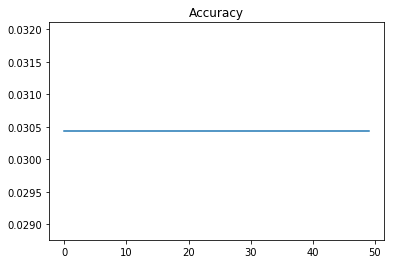

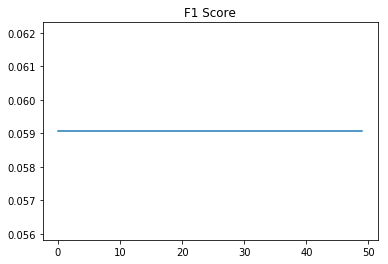

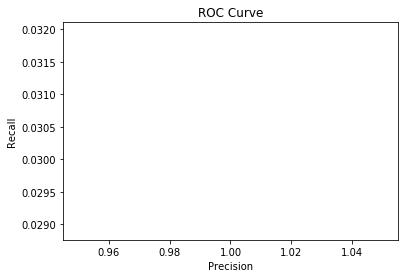

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(accuracy)
plt.title('Accuracy')
plt.show()
plt.plot(f1)
plt.title('F1 Score')
plt.show()
plt.plot(precision, recall)
plt.title('ROC Curve')
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

In [31]:
np.sum(labelBatchFeed)

32065.0

In [32]:
labelBatchFeed.shape

(10536, 100, 1)

In [33]:
32065/(10536*100.0)

0.030433750949126804

In [ ]:
#calculate best move ranking frequency for NN

#for each fen

#get features from fen (one sample for each move from fen)

#batch features, padding batches with zeros (use batch size of one if possib;e)

#start session and evaluate batches